In [1]:
%load_ext watermark


In [2]:
import itertools as it
import operator
import os

import alifedata_phyloinformatics_convert as apc
from hstrat._auxiliary_lib import (
    # alifestd_collapse_unifurcations,
    alifestd_downsample_tips_asexual,
    alifestd_downsample_tips_clade_asexual,
    alifestd_join_roots,
    alifestd_mark_leaves,
    alifestd_mark_origin_time_delta_asexual,
    alifestd_prune_extinct_lineages_asexual,
    alifestd_to_working_format,
    alifestd_try_add_ancestor_list_col,
)
import iplotx as ipx
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from pyfonts import load_google_font
from teeplot import teeplot as tp
from scipy import stats as scipy_stats
import seaborn as sns


/usr/local/lib/python3.10/dist-packages/alifedata_phyloinformatics_convert/_impl/phytrack_Systematcs.py:7: UserWarning: ImportWarning: phylotrackpy.Systematics import failed; inserting a no-op mock for Systematics. This is likely because phylotrackpy is not installed.
  warnings.warn(


In [3]:
%watermark -diwmuv -iv


Last updated: 2026-02-15T00:59:47.935010+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1044-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

iplotx                            : 1.7.0
numpy                             : 2.1.2
seaborn                           : 0.13.2
teeplot                           : 1.4.2
alifedata_phyloinformatics_convert: 0.19.3
matplotlib                        : 3.10.0
pandas                            : 2.2.3
polars                            : 1.37.1
scipy                             : 1.14.1

Watermark: 2.4.3



In [4]:
teeplot_subdir = os.environ.get(
    "NOTEBOOK_NAME", "2026-02-12-billion-tip-phylos"
)
teeplot_subdir


'2026-02-12-billion-tip-phylos'

In [5]:
font = load_google_font("Merriweather", weight=300)
mpl.font_manager.fontManager.addfont(font.get_file())
plt.rcParams['font.family'] = font.get_name()


## Prep Data


In [6]:
phylo1_df = alifestd_try_add_ancestor_list_col(
    alifestd_mark_origin_time_delta_asexual(
        alifestd_to_working_format(
            alifestd_join_roots(
                pl.read_parquet("https://osf.io/download/485tx").to_pandas(),
            ),
        ),
    ),
)
phylo1_df


,id,dstream_data_id,ancestor_id,layer,position,globalSeed,nCol,nRow,nWav,nTrait,...,CEREBRASLIB_TRAITLOGGER_DSTREAM_ALGO_NAME,ASYNC_GA_GENOME_FLAVOR,data_hex,origin_time,hstrat_rank_from_t0,is_root,is_oldest_root,ancestor_origin_time,origin_time_delta,ancestor_list
0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,NaN,NaN,True,True,NaN,NaN,[none]
1,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,NaN,NaN,False,False,NaN,NaN,[0]
2,2,9.223372e+18,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,262079.0,262079.0,False,False,NaN,NaN,[0]
3,3,9.223372e+18,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,393151.0,393151.0,False,False,262079.0,131072.0,[2]
4,4,9.223372e+18,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,458687.0,458687.0,False,False,393151.0,65536.0,[3]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99904,99904,9.992772e+08,99261,2499.0,160541.0,1.0,755.0,1170.0,5.0,1.0,...,steady_algo,genome_purifyingonly,bf7ffe4400123b6ab2c2d805f76e3a980e1d3dd0,1194793.0,1194793.0,False,False,1187887.0,6906.0,[99261]
99905,99905,9.992853e+08,95513,2499.0,168630.0,1.0,755.0,1170.0,5.0,1.0,...,steady_algo,genome_purifyingonly,bf7ffe4400123bcb15b22f7fb13bdcf7923938ba,1194890.0,1194890.0,False,False,1160639.0,34251.0,[95513]
99906,99906,9.996592e+08,94155,2499.0,542538.0,1.0,755.0,1170.0,5.0,1.0,...,steady_algo,genome_purifyingonly,bf7ffe4500123c8fae9449b9c67a57365fcbff2b,1195086.0,1195086.0,False,False,1159103.0,35983.0,[94155]
99907,99907,9.994994e+08,83917,2499.0,382743.0,1.0,755.0,1170.0,5.0,1.0,...,steady_algo,genome_purifyingonly,bf7ffe4400123d3f4a5f1550deb0d7da5fcbff2b,1195262.0,1195262.0,False,False,1105295.0,89967.0,[83917]


In [7]:
phylo2_df = alifestd_try_add_ancestor_list_col(
    alifestd_mark_origin_time_delta_asexual(
        alifestd_to_working_format(
            alifestd_join_roots(
                pl.read_parquet("https://osf.io/download/vkzdw").to_pandas(),
            ),
        ),
    )
)
phylo2_df


,id,dstream_data_id,ancestor_id,layer,position,globalSeed,nCol,nRow,nWav,nTrait,...,CEREBRASLIB_TRAITLOGGER_DSTREAM_ALGO_NAME,ASYNC_GA_GENOME_FLAVOR,data_hex,origin_time,hstrat_rank_from_t0,is_root,is_oldest_root,ancestor_origin_time,origin_time_delta,ancestor_list
0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,NaN,NaN,True,True,NaN,NaN,[none]
1,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,NaN,NaN,False,False,NaN,NaN,[0]
2,2,9.223372e+18,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,262079.0,262079.0,False,False,NaN,NaN,[0]
3,3,9.223372e+18,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,393151.0,393151.0,False,False,262079.0,131072.0,[2]
4,4,9.223372e+18,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,458687.0,458687.0,False,False,393151.0,65536.0,[3]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99925,99925,9.997067e+08,96953,2499.0,590051.0,2.0,755.0,1170.0,5.0,1.0,...,steady_algo,genome_purifyingplus,bf7ffe1c0013f082e946554a438e0ebcbfba30e3,1306689.0,1306689.0,False,False,1281087.0,25602.0,[96953]
99926,99926,9.994150e+08,99292,2499.0,298307.0,2.0,755.0,1170.0,5.0,1.0,...,steady_algo,genome_purifyingplus,bf7ffe180013f0ca2a915b07740a47c98ebb527e,1306761.0,1306761.0,False,False,1298623.0,8138.0,[99292]
99927,99927,9.998592e+08,94803,2499.0,742514.0,2.0,755.0,1170.0,5.0,1.0,...,steady_algo,genome_purifyingplus,bf7ffe1e0013f1366c12edb6d7de8c1699dd1964,1306869.0,1306869.0,False,False,1267647.0,39222.0,[94803]
99928,99928,9.996051e+08,99880,2499.0,488465.0,2.0,755.0,1170.0,5.0,1.0,...,steady_algo,genome_purifyingplus,bf7ffe1c0013f1a7c9ed70d92f1050d66b5c440b,1306982.0,1306982.0,False,False,1304255.0,2727.0,[99880]


In [8]:
phylo1_df["x"] = phylo1_df["position"] // phylo1_df["nCol"]
phylo1_df["x_"] = phylo1_df["x"] / phylo1_df["nRow"]
phylo1_df["y"] =phylo1_df["position"] % phylo1_df["nCol"]
phylo1_df["y_"] = phylo1_df["y"] / phylo1_df["nCol"]

phylo2_df["x"] = phylo2_df["position"] // phylo2_df["nCol"]
phylo2_df["x_"] = phylo2_df["x"] / phylo2_df["nRow"]
phylo2_df["y"] =phylo2_df["position"] % phylo2_df["nCol"]
phylo2_df["y_"] = phylo2_df["y"] / phylo2_df["nCol"]

phylo1_df["taxon_label"] = phylo1_df["id"].astype(str)
phylo2_df["taxon_label"] = phylo2_df["id"].astype(str)

phylo1_df["log_origin_time_delta"] = np.log(phylo1_df["origin_time_delta"] + 1)
phylo2_df["log_origin_time_delta"] = np.log(phylo2_df["origin_time_delta"] + 1)


In [9]:
phylo1_df = alifestd_mark_leaves(phylo1_df)
phylo2_df = alifestd_mark_leaves(phylo2_df)


In [10]:
phylo1_df["regime"] = "purifying"
phylo2_df["regime"] = "adaptive"


In [11]:
leaves1_df = phylo1_df[phylo1_df["is_leaf"]]
leaves2_df = phylo2_df[phylo2_df["is_leaf"]]


## Origin Time Stats


In [12]:
v1, v2 = map(
    float,
    (leaves1_df["origin_time"].mean(), leaves2_df["origin_time"].mean()),
)
v1, v2, v1 / v2


(942139.21056, 992367.65002, 0.9493852510619551)

In [13]:
v1, v2 = map(
    float,
    (leaves1_df["origin_time"].median(), leaves2_df["origin_time"].median()),
)
v1, v2, v1 / v2


(954125.0, 990815.5, 0.9629693923843541)

In [14]:
v1, v2 = map(
    float,
    (leaves1_df["origin_time"].max(), leaves2_df["origin_time"].max()),
)
v1, v2, v1 / v2


(1195285.0, 1307002.0, 0.9145242317915351)

In [15]:
v1, v2 = map(
    float,
    (leaves1_df["origin_time"].min(), leaves2_df["origin_time"].min()),
)
v1, v2, v1 / v2


(662803.0, 684307.0, 0.9685755077764805)

In [16]:
scipy_stats.mannwhitneyu(
    leaves1_df["origin_time"].dropna(),
    leaves2_df["origin_time"].dropna(),
)


MannwhitneyuResult(statistic=np.float64(1051836136.5), pvalue=np.float64(0.0))

teeplots/hue=regime+viz=kdeplot+x=origin-time+ext=.pdf
teeplots/hue=regime+viz=kdeplot+x=origin-time+ext=.png


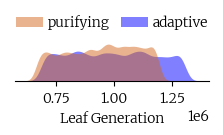

teeplots/hue=regime+viz=kdeplot+x=origin-time+ext=.pdf
teeplots/hue=regime+viz=kdeplot+x=origin-time+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/hue=regime+viz=kdeplot+x=origin-time+ext=.pdf, overwriting it
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/hue=regime+viz=kdeplot+x=origin-time+ext=.png, overwriting it
  warnings.warn(


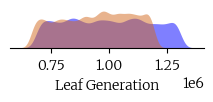

In [17]:
for legend in [True, False]:
    with tp.teed(
        sns.kdeplot,
        data=pd.concat([leaves1_df, leaves2_df], ignore_index=True),
        x="origin_time",
        alpha=0.5,
        common_norm=False,
        hue="regime",
        hue_order=["purifying", "adaptive"],
        fill=True,
        legend=legend,
        linewidth=0,
        palette=["chocolate", "blue"],
    ) as teed:
        if legend:
            sns.move_legend(
                teed,
                "lower center",
                bbox_to_anchor=(.5, 1),
                columnspacing=0.8,
                frameon=False,
                handletextpad=0.3,
                ncol=3,
                title=None,
            )
        sns.despine(ax=teed, left=True)
        teed.set_yticks([])
        teed.figure.set_size_inches(2.5, 0.5)
        teed.set_xlabel("Leaf Generation")
        teed.set_ylabel("")


## Origin Time Delta Stats


In [18]:
phylo1_df["ot_delta"] = phylo1_df["origin_time_delta"]
phylo2_df["ot_delta"] = phylo2_df["origin_time_delta"]


In [19]:
v1, v2 = map(
    float,
    (phylo1_df["ot_delta"].mean(), phylo2_df["ot_delta"].mean()),
)
v1, v2, v1 / v2


(19480.658465542267, 14617.052148589957, 1.332735100587397)

In [20]:
v1, v2 = map(
    float,
    (phylo1_df["ot_delta"].median(), phylo2_df["ot_delta"].median()),
)
v1, v2, v1 / v2


(13659.0, 9344.0, 1.4617936643835616)

In [21]:
v1, v2 = map(
    float,
    (phylo1_df["ot_delta"].max(), phylo2_df["ot_delta"].max()),
)
v1, v2, v1 / v2


(239085.0, 239616.0, 0.9977839543269231)

In [22]:
v1, v2 = map(
    float,
    (phylo1_df["ot_delta"].min(), phylo2_df["ot_delta"].min()),
)
v1, v2


(1.0, 0.0)

In [23]:
scipy_stats.mannwhitneyu(
    phylo1_df["origin_time_delta"].dropna(),
    phylo2_df["origin_time_delta"].dropna(),
)


MannwhitneyuResult(statistic=np.float64(5881120161.0), pvalue=np.float64(0.0))

teeplots/hue=regime+viz=kdeplot+x=origin-time-delta+ext=.pdf
teeplots/hue=regime+viz=kdeplot+x=origin-time-delta+ext=.png


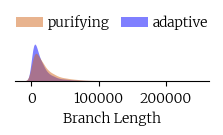

teeplots/hue=regime+viz=kdeplot+x=origin-time-delta+ext=.pdf
teeplots/hue=regime+viz=kdeplot+x=origin-time-delta+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/hue=regime+viz=kdeplot+x=origin-time-delta+ext=.pdf, overwriting it
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/hue=regime+viz=kdeplot+x=origin-time-delta+ext=.png, overwriting it
  warnings.warn(


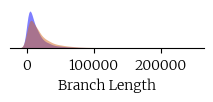

teeplots/hue=regime+viz=kdeplot+x=log-origin-time-delta+ext=.pdf
teeplots/hue=regime+viz=kdeplot+x=log-origin-time-delta+ext=.png


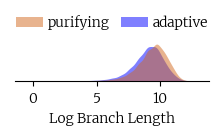

teeplots/hue=regime+viz=kdeplot+x=log-origin-time-delta+ext=.pdf
teeplots/hue=regime+viz=kdeplot+x=log-origin-time-delta+ext=.png


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/hue=regime+viz=kdeplot+x=log-origin-time-delta+ext=.pdf, overwriting it
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/hue=regime+viz=kdeplot+x=log-origin-time-delta+ext=.png, overwriting it
  warnings.warn(


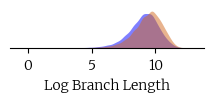

In [24]:
for x, legend in it.product(
    ["origin_time_delta", "log_origin_time_delta"],
    [True, False],
):
    with tp.teed(
        sns.kdeplot,
        data=pd.concat([phylo1_df, phylo2_df], ignore_index=True),
        x=x,
        alpha=0.5,
        bw_adjust=2.0,
        common_norm=False,
        hue="regime",
        hue_order=["purifying", "adaptive"],
        fill=True,
        legend=legend,
        linewidth=0,
        palette=["chocolate", "blue"],
    ) as teed:
        if legend:
            sns.move_legend(
                teed,
                "lower center",
                bbox_to_anchor=(.5, 1),
                columnspacing=0.8,
                frameon=False,
                handletextpad=0.3,
                ncol=3,
                title=None,
            )
        sns.despine(ax=teed, left=True)
        teed.set_yticks([])
        teed.figure.set_size_inches(2.5, 0.5)
        teed.set_xlabel(
            {
                "origin_time_delta": "Branch Length",
                "log_origin_time_delta": "Log Branch Length",
            }[x],
        )
        teed.set_ylabel("")


## Create Color Map


In [25]:
def get_bcyr_color(x: float, y: float) -> tuple[float, float, float]:
    return (y, x, 1.0 - y)


def get_bcyr_hex(x: float, y: float) -> str:
    return mpl.colors.to_hex(get_bcyr_color(x, y))


In [26]:
phylo1_df["bcyr"] = phylo1_df.apply(
    lambda row: get_bcyr_color(row["x_"], row["y_"]), axis=1
)
phylo2_df["bcyr"] = phylo2_df.apply(
    lambda row: get_bcyr_color(row["x_"], row["y_"]), axis=1
)

phylo1_df["bcyr"], phylo2_df["bcyr"]


(0                                          (nan, nan, nan)
 1                                          (nan, nan, nan)
 2                                          (nan, nan, nan)
 3                                          (nan, nan, nan)
 4                                          (nan, nan, nan)
                                ...                        
 99904    (0.6370860927152318, 0.1811965811965812, 0.362...
 99905    (0.3509933774834437, 0.1905982905982906, 0.649...
 99906    (0.5933774834437087, 0.6136752136752137, 0.406...
 99907    (0.9443708609271523, 0.4324786324786325, 0.055...
 99908    (0.8556291390728477, 0.4307692307692308, 0.144...
 Name: bcyr, Length: 99909, dtype: object,
 0                                          (nan, nan, nan)
 1                                          (nan, nan, nan)
 2                                          (nan, nan, nan)
 3                                          (nan, nan, nan)
 4                                          (nan, nan, na

teeplots/2026-02-12-billion-tip-phylos/aspect=auto+cmap=bcyr+val=0+viz=imshow+what=xstrip+ext=.pdf
teeplots/2026-02-12-billion-tip-phylos/aspect=auto+cmap=bcyr+val=0+viz=imshow+what=xstrip+ext=.png


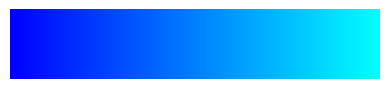

teeplots/2026-02-12-billion-tip-phylos/aspect=auto+cmap=bcyr+val=0.5+viz=imshow+what=xstrip+ext=.pdf
teeplots/2026-02-12-billion-tip-phylos/aspect=auto+cmap=bcyr+val=0.5+viz=imshow+what=xstrip+ext=.png


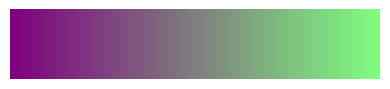

teeplots/2026-02-12-billion-tip-phylos/aspect=auto+cmap=bcyr+val=1.0+viz=imshow+what=xstrip+ext=.pdf
teeplots/2026-02-12-billion-tip-phylos/aspect=auto+cmap=bcyr+val=1.0+viz=imshow+what=xstrip+ext=.png


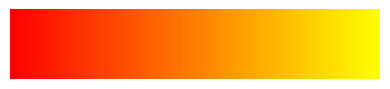

In [27]:
for y_val in (0, 0.5, 1.0):
    fig, ax = plt.subplots(figsize=(5, 1))

    x_vals = np.linspace(0.0, 1.0, 256)
    colors = [get_bcyr_color(x, y_val) for x in x_vals]

    # Create colorbar
    cb_data = np.array([x_vals])
    with tp.teed(
        plt.imshow,
        cb_data,
        aspect="auto",
        cmap=mpl.colors.ListedColormap(colors),
        extent=[0, 1, 0, 1],
        teeplot_outattrs={"cmap": "bcyr", "what": "xstrip", "val": y_val},
        teeplot_subdir=teeplot_subdir,
    ) as im:
        ax.figure.set_size_inches(4, 1)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_xlabel("")
        sns.despine(ax=ax, left=True, bottom=True)

        plt.tight_layout()


teeplots/2026-02-12-billion-tip-phylos/aspect=auto+cmap=bcyr+val=0+viz=imshow+what=ystrip+ext=.pdf
teeplots/2026-02-12-billion-tip-phylos/aspect=auto+cmap=bcyr+val=0+viz=imshow+what=ystrip+ext=.png


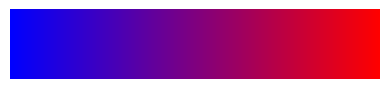

teeplots/2026-02-12-billion-tip-phylos/aspect=auto+cmap=bcyr+val=0.5+viz=imshow+what=ystrip+ext=.pdf
teeplots/2026-02-12-billion-tip-phylos/aspect=auto+cmap=bcyr+val=0.5+viz=imshow+what=ystrip+ext=.png


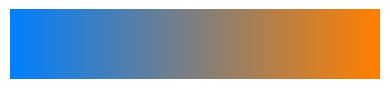

teeplots/2026-02-12-billion-tip-phylos/aspect=auto+cmap=bcyr+val=1.0+viz=imshow+what=ystrip+ext=.pdf
teeplots/2026-02-12-billion-tip-phylos/aspect=auto+cmap=bcyr+val=1.0+viz=imshow+what=ystrip+ext=.png


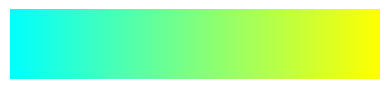

In [28]:
for x_val in (0, 0.5, 1.0):
    fig, ax = plt.subplots(figsize=(5, 1))

    y_vals = np.linspace(0.0, 1.0, 256)
    colors = [get_bcyr_color(x_val, y) for y in y_vals]

    # Create colorbar
    cb_data = np.array([y_vals])
    with tp.teed(
        plt.imshow,
        cb_data,
        aspect="auto",
        cmap=mpl.colors.ListedColormap(colors),
        extent=[0, 1, 0, 1],
        teeplot_outattrs={"cmap": "bcyr", "what": "ystrip", "val": x_val},
        teeplot_subdir=teeplot_subdir,
    ) as im:
        ax.figure.set_size_inches(4, 1)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_xlabel("")
        sns.despine(ax=ax, left=True, bottom=True)

        plt.tight_layout()


teeplots/2026-02-12-billion-tip-phylos/aspect=1x1+cmap=bcyr+viz=imshow+what=area+ext=.pdf
teeplots/2026-02-12-billion-tip-phylos/aspect=1x1+cmap=bcyr+viz=imshow+what=area+ext=.png


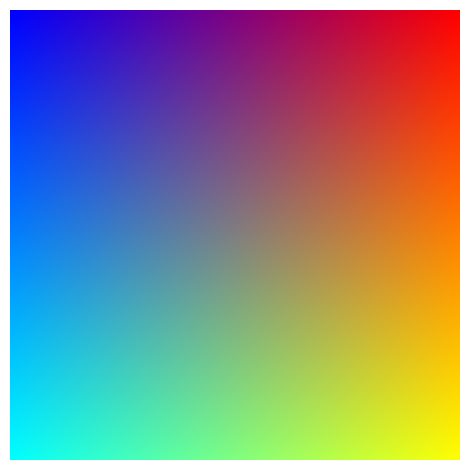

teeplots/2026-02-12-billion-tip-phylos/aspect=755x1170+cmap=bcyr+viz=imshow+what=area+ext=.pdf
teeplots/2026-02-12-billion-tip-phylos/aspect=755x1170+cmap=bcyr+viz=imshow+what=area+ext=.png


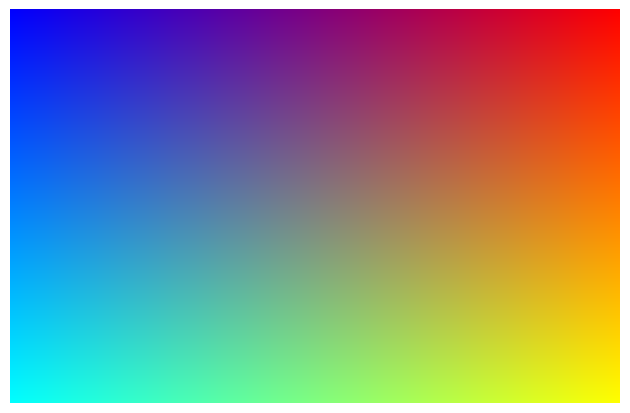

In [29]:
for aspect in (1, 1), (755, 1170):
    with tp.teed(
        plt.imshow,
        X=[
            [get_bcyr_color(x / 255, y / 255) for y in range(256)]
            for x in range(256)
        ],
        teeplot_outattrs={
            "aspect": "x".join(map(str, aspect)),
            "cmap": "bcyr",
            "what": "area",
        },
        teeplot_subdir=teeplot_subdir,
    ) as teed:
        plt.gca().xaxis.set_visible(False)
        plt.gca().yaxis.set_visible(False)
        sns.despine(ax=plt.gca(), left=True, bottom=True)
        plt.gca().set_aspect(aspect=operator.truediv(*aspect))
        plt.gcf().tight_layout()


## Plotting Helpers


In [30]:
bcyr_lookup1 = dict(zip(phylo1_df["taxon_label"], phylo1_df["bcyr"]))
bcyr_lookup2 = dict(zip(phylo2_df["taxon_label"], phylo2_df["bcyr"]))


In [31]:
def overlay_tip_dots(
    ax: plt.Axes,
    tree_result: ipx.plotting.TreeArtist,
    bcyr_lookup: dict,
    radial: bool = False,
    size: float = 4,
):
    layout = tree_result.get_layout()
    xs, ys, colors = [], [], []
    for (node, (x, y)), (x_, y_) in zip(
        layout.T.items(),
        tree_result.get_nodes().get_offsets(),
    ):
        if node.taxon is not None:
            label = str(node.taxon.label)
            if label in bcyr_lookup:
                color = bcyr_lookup[label]
                if (
                    color[0] != color[0]
                    or color[1] != color[1]
                    or color[2] != color[2]
                ):  # Check for NaN
                    continue
                if radial:
                    # x = x * np.cos(y)
                    # y = x * np.sin(y)
                    x = x_
                    y = y_
                xs.append(x)
                ys.append(y)
                colors.append(color)

    ax.scatter(xs, ys, c=colors, s=size, zorder=10, edgecolors="none")


## Whole-tree Sample


In [32]:
tree1 = apc.RosettaTree(
    alifestd_downsample_tips_asexual(phylo1_df, 250, seed=1),
).as_dendropy
tree2 = apc.RosettaTree(
    alifestd_downsample_tips_asexual(phylo2_df, 250, seed=1),
).as_dendropy


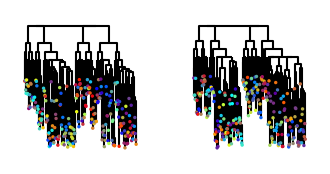

teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=down+viz=subplots+ext=.pdf
teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=down+viz=subplots+ext=.png


<Figure size 640x480 with 0 Axes>

In [33]:
tree1.ladderize()
tree2.ladderize()

with tp.teed(
    plt.subplots,
    1,
    2,
    figsize=(4, 2),
    teeplot_outattrs={"layout": "vertical", "sample": "down"},
    teeplot_subdir=teeplot_subdir,
) as teed:
    fig, (ax1, ax2) = teed
    tr1 = ipx.plotting.tree(
        tree1,
        ax=ax1,
        layout="vertical",
        edge_linewidth=1.5,
        margins=0.0,
    )
    tr2 = ipx.plotting.tree(
        tree2,
        ax=ax2,
        layout="vertical",
        edge_linewidth=1.5,
        margins=0.0,
    )
    overlay_tip_dots(ax1, tr1, bcyr_lookup1, size=6)
    overlay_tip_dots(ax2, tr2, bcyr_lookup2, size=6)
    plt.show()


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=down+viz=subplots+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=down+viz=subplots+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=down+viz=subplots+ext=.png, overwriting it
  warnings.warn(


teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=down+viz=subplots+ext=.png


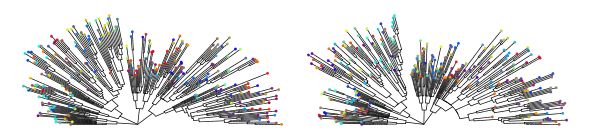

In [34]:
tree1.ladderize()
tree2.ladderize()

with tp.teed(
    plt.subplots,
    1,
    2,
    figsize=(6, 1.5),
    gridspec_kw={
        "wspace": 0.0,
        "hspace": 0.0,
    },
    teeplot_outattrs={"layout": "vertical", "sample": "down"},
    teeplot_subdir=teeplot_subdir,
) as teed:
    fig, (ax1, ax2) = teed

    style = [
        "tree",
        {
            "layout": {
                "start": -180,
                "span": 180,
            },
        },
    ]
    tr1 = ipx.plotting.tree(
        tree1,
        ax=ax1,
        layout="radial",
        # layout_orientation="right",
        edge_linewidth=0.5,
        margins=-0.02,
        style=style,
    )
    tr2 = ipx.plotting.tree(
        tree2,
        ax=ax2,
        angle=270,
        layout="radial",
        # layout_orientation="right",
        edge_linewidth=0.5,
        margins=-0.02,
        style=style,
    )
    overlay_tip_dots(ax1, tr1, bcyr_lookup1, radial=True, size=4)
    overlay_tip_dots(ax2, tr2, bcyr_lookup2, radial=True, size=4)
    fig.tight_layout()


## Clade Sample


In [35]:
df1 = alifestd_downsample_tips_clade_asexual(phylo1_df, 4_000, seed=2)
tree1 = apc.RosettaTree(df1).as_dendropy
df2 = alifestd_downsample_tips_clade_asexual(phylo2_df, 4_000, seed=2)
tree2 = apc.RosettaTree(df2).as_dendropy

tree1.ladderize()
tree2.ladderize()


teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=clade+viz=subplots+ext=.pdf
teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=clade+viz=subplots+ext=.png


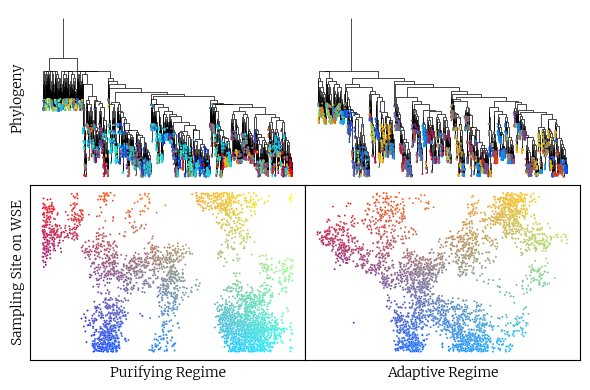

In [36]:
with tp.teed(
    plt.subplots,
    2,
    2,
    figsize=(6, 4),
    gridspec_kw={
        "wspace": 0.0,
        "hspace": 0.0,
    },
    teeplot_outattrs={"layout": "vertical", "sample": "clade"},
    teeplot_subdir=teeplot_subdir,
) as teed:
    fig, ((ax1, ax2), (ax3, ax4)) = teed
    tr1 = ipx.plotting.tree(
        tree1,
        ax=ax1,
        layout="vertical",
        edge_linewidth=0.5,
        margins=-0.02,
    )
    tr2 = ipx.plotting.tree(
        tree2,
        ax=ax2,
        layout="vertical",
        edge_linewidth=0.5,
        margins=-0.02,
    )
    overlay_tip_dots(ax1, tr1, bcyr_lookup1, size=2)
    overlay_tip_dots(ax2, tr2, bcyr_lookup2, size=2)
    sns.scatterplot(
        data=df1.dropna(subset=["x_", "y_"]),
        x="x",
        y="y",
        color=[
            get_bcyr_hex(row["x_"], row["y_"])
            for _, row in df1.dropna(subset=["x_", "y_"]).iterrows()
        ],
        ax=ax3,
        legend=False,
        clip_on=False,
        s=2,
    )
    sns.scatterplot(
        data=df2.dropna(subset=["x_", "y_"]),
        x="x",
        y="y",
        color=[
            get_bcyr_hex(row["x_"], row["y_"])
            for _, row in df2.dropna(subset=["x_", "y_"]).iterrows()
        ],
        ax=ax4,
        legend=False,
        s=2,
        clip_on=False,
    )
    ax1.set_ylabel("Phylogeny")
    ax3.set_xlabel("Purifying Regime")
    ax3.set_xticks([])
    ax3.set_ylabel("Sampling Site on WSE")
    ax3.set_yticks([])

    ax4.set_xlabel("Adaptive Regime")
    ax4.set_xticks([])
    ax4.set_ylabel("")
    ax4.set_yticks([])

    fig.tight_layout()


teeplots/2026-02-12-billion-tip-phylos/layout=vertical+regime=purifying+sample=clade+viz=tree+ext=.pdf
teeplots/2026-02-12-billion-tip-phylos/layout=vertical+regime=purifying+sample=clade+viz=tree+ext=.png


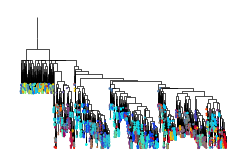

teeplots/2026-02-12-billion-tip-phylos/layout=vertical+regime=adaptive+sample=clade+viz=tree+ext=.pdf
teeplots/2026-02-12-billion-tip-phylos/layout=vertical+regime=adaptive+sample=clade+viz=tree+ext=.png


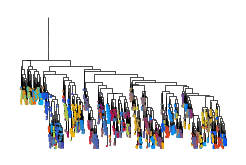

In [37]:
for regime, (tree, lookup) in {
    "purifying": (tree1, bcyr_lookup1),
    "adaptive": (tree2, bcyr_lookup2),
}.items():
    with tp.teed(
        ipx.plotting.tree,
        tree,
        layout="vertical",
        edge_linewidth=0.5,
        margins=-0.02,
        teeplot_outattrs={
            "layout": "vertical",
            "regime": regime,
            "sample": "clade",
        },
        teeplot_subdir=teeplot_subdir,
    ) as teed:
        overlay_tip_dots(plt.gca(), teed, lookup, size=2)
        plt.gcf().set_size_inches(1170 / 400, 755 / 400)


teeplots/2026-02-12-billion-tip-phylos/regime=purifying+sample=clade+viz=scatterplot+x=x+y=y+ext=.pdf
teeplots/2026-02-12-billion-tip-phylos/regime=purifying+sample=clade+viz=scatterplot+x=x+y=y+ext=.png


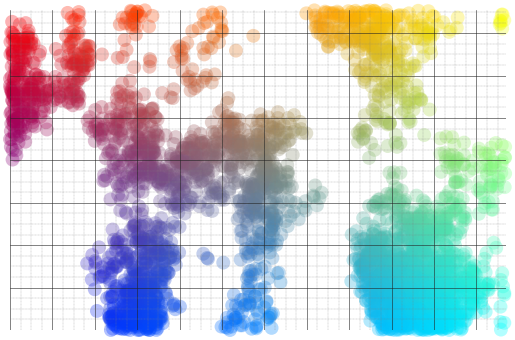

teeplots/2026-02-12-billion-tip-phylos/regime=adaptive+sample=clade+viz=scatterplot+x=x+y=y+ext=.pdf
teeplots/2026-02-12-billion-tip-phylos/regime=adaptive+sample=clade+viz=scatterplot+x=x+y=y+ext=.png


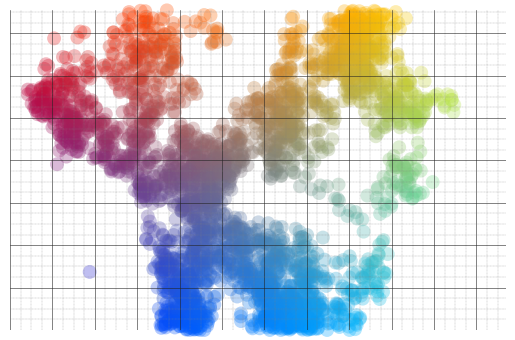

In [38]:
for regime, data in {
    "purifying": df1,
    "adaptive": df2,
}.items():
    with tp.teed(
        sns.scatterplot,
        data=data.dropna(subset=["x_", "y_"]),
        x="x",
        y="y",
        color=[
            get_bcyr_hex(row["x_"], row["y_"])
            for _, row in data.dropna(subset=["x_", "y_"]).iterrows()
        ],
        legend=False,
        linewidth=0,
        edgecolor=None,
        s=100,
        alpha=0.3,
        clip_on=False,
        zorder=-100,
        teeplot_outattrs={"regime": regime, "sample": "clade"},
        teeplot_subdir=teeplot_subdir,
    ) as teed:

        teed.xaxis.set_major_locator(plt.MultipleLocator(100))
        teed.xaxis.set_minor_locator(plt.MultipleLocator(25))
        teed.yaxis.set_major_locator(plt.MultipleLocator(100))
        teed.yaxis.set_minor_locator(plt.MultipleLocator(25))
        teed.grid(visible=True, which="major", color="#222222", lw=0.4)
        teed.grid(
            visible=True, which="minor", color="gray", ls="--", linewidth=0.2
        )
        teed.tick_params(axis="both", which="both", length=0)
        teed.set_xticklabels([])
        teed.set_yticklabels([])
        teed.set_xlabel("")
        teed.set_ylabel("")
        teed.set_xlim(0, data["nRow"].max())
        teed.set_ylim(0, data["nCol"].max())
        teed.set_aspect("equal")
        sns.despine(ax=teed, left=True, bottom=True)


teeplots/2026-02-12-billion-tip-phylos/layout=radial+sample=clade+viz=subplots+ext=.pdf
teeplots/2026-02-12-billion-tip-phylos/layout=radial+sample=clade+viz=subplots+ext=.png


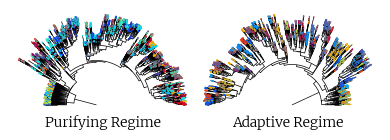

In [39]:
with tp.teed(
    plt.subplots,
    1,
    2,
    figsize=(4, 1.5),
    gridspec_kw={
        "wspace": 0.0,
        "hspace": 0.0,
    },
    teeplot_outattrs={"layout": "radial", "sample": "clade"},
    teeplot_subdir=teeplot_subdir,
) as teed:
    fig, (ax1, ax2) = teed

    style = [
        "tree",
        {
            "layout": {
                "start": -180,
                "span": 180,
            },
        },
    ]
    tr1 = ipx.plotting.tree(
        tree1,
        ax=ax1,
        layout="radial",
        # layout_orientation="right",
        edge_linewidth=0.5,
        margins=-0.02,
        style=style,
    )
    tr2 = ipx.plotting.tree(
        tree2,
        ax=ax2,
        angle=270,
        layout="radial",
        # layout_orientation="right",
        edge_linewidth=0.5,
        margins=-0.02,
        style=style,
    )
    overlay_tip_dots(ax1, tr1, bcyr_lookup1, radial=True, size=1)
    overlay_tip_dots(ax2, tr2, bcyr_lookup2, radial=True, size=1)
    ax1.set_xlabel("Purifying Regime")
    ax2.xaxis.set_inverted(True)
    ax2.set_xlabel("Adaptive Regime")
    fig.tight_layout()


## Canopy Sample


In [40]:
n = 4_000
phylo1_df["extant"] = False
phylo1_df.loc[phylo1_df["is_leaf"], "extant"] = (
    phylo1_df.loc[phylo1_df["is_leaf"], "origin_time"].rank(
        ascending=False,
        method="first",
    )
    <= n
)
phylo2_df["extant"] = False
phylo2_df.loc[phylo2_df["is_leaf"], "extant"] = (
    phylo2_df.loc[phylo2_df["is_leaf"], "origin_time"].rank(
        ascending=False,
        method="first",
    )
    <= n
)

phylo1_df["extant"].sum(), phylo2_df["extant"].sum()


(np.int64(4000), np.int64(4000))

In [41]:
tree1 = apc.RosettaTree(
    # alifestd_mark_origin_time_delta_asexual(
    #     alifestd_collapse_unifurcations(
    alifestd_prune_extinct_lineages_asexual(phylo1_df),
    #     ),
    # ),
).as_dendropy
tree2 = apc.RosettaTree(
    # alifestd_mark_origin_time_delta_asexual(
    #     alifestd_collapse_unifurcations(
    alifestd_prune_extinct_lineages_asexual(phylo2_df),
    # ),
    # ),
).as_dendropy

tree1.ladderize()
tree2.ladderize()


teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=canopy+viz=subplots+ext=.pdf
teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=canopy+viz=subplots+ext=.png


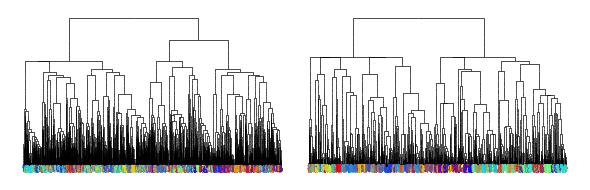

In [42]:
with tp.teed(
    plt.subplots,
    1,
    2,
    figsize=(6, 2),
    gridspec_kw={
        "wspace": 0.0,
        "hspace": 0.0,
    },
    teeplot_outattrs={"layout": "vertical", "sample": "canopy"},
    teeplot_subdir=teeplot_subdir,
) as teed:
    fig, (ax1, ax2) = teed
    tr1 = ipx.plotting.tree(
        tree1,
        ax=ax1,
        layout="vertical",
        edge_linewidth=0.5,
        margins=-0.02,
    )
    tr2 = ipx.plotting.tree(
        tree2,
        ax=ax2,
        layout="vertical",
        edge_linewidth=0.5,
        margins=-0.02,
    )
    overlay_tip_dots(ax1, tr1, bcyr_lookup1, size=2)
    overlay_tip_dots(ax2, tr2, bcyr_lookup2, size=2)
    fig.tight_layout()


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=canopy+viz=subplots+ext=.pdf, overwriting it
  warnings.warn(


teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=canopy+viz=subplots+ext=.pdf


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:324: UserWarning: teeplot already created file teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=canopy+viz=subplots+ext=.png, overwriting it
  warnings.warn(


teeplots/2026-02-12-billion-tip-phylos/layout=vertical+sample=canopy+viz=subplots+ext=.png


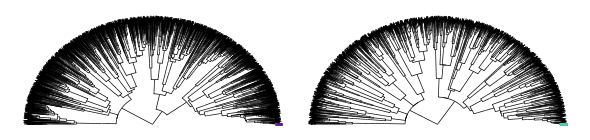

In [43]:
with tp.teed(
    plt.subplots,
    1,
    2,
    figsize=(6, 1.5),
    gridspec_kw={
        "wspace": 0.0,
        "hspace": 0.0,
    },
    teeplot_outattrs={"layout": "vertical", "sample": "canopy"},
    teeplot_subdir=teeplot_subdir,
) as teed:
    fig, (ax1, ax2) = teed

    style = [
        "tree",
        {
            "layout": {
                "start": -180,
                "span": 180,
            },
        },
    ]
    tr1 = ipx.plotting.tree(
        tree1,
        ax=ax1,
        layout="radial",
        # layout_orientation="right",
        edge_linewidth=0.5,
        margins=-0.02,
        style=style,
    )
    tr2 = ipx.plotting.tree(
        tree2,
        ax=ax2,
        angle=270,
        layout="radial",
        # layout_orientation="right",
        edge_linewidth=0.5,
        margins=-0.02,
        style=style,
    )
    overlay_tip_dots(ax1, tr1, bcyr_lookup1, size=2)
    overlay_tip_dots(ax2, tr2, bcyr_lookup2, size=2)
    fig.tight_layout()
